In [20]:
import glob
import math
import time
import operator
import cv2
from moviepy.editor import VideoFileClip
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label

In [2]:
def load_images(files, num=0):
    imgs = None
    files_sel = []
    
    if num == 0: 
        num = len(files)
        files_sel = files
    else:
        for i in range(num):
            idx = np.random.choice(len(files), 1)[0]
            files_sel.append(files[idx])
            
    for fname in files_sel:
        img = cv2.imread(fname)
        
        if imgs is None:
            imgs = np.empty([0, img.shape[0], img.shape[1], img.shape[2]], dtype = np.uint8)
            
        imgs = np.append(imgs, img[None,:], axis=0)
        
    return imgs

def display_image_set(imgs, filename, cols_num=6):
    height_init, width_init, _ = imgs[0].shape
    
    if width_init > 300:
        width_img = int(math.ceil(float(300) / float(cols_num)))
    else:
        width_img = width_init
        
    imgs_num = len(imgs)
    rows_num = int(math.ceil(float(imgs_num) / float(cols_num)))
    Kwidth = float(width_init) / float(width_img)
    height_img = int(height_init / Kwidth)
    result_shape = (rows_num * height_img, cols_num * width_img, 3)
    results_image = 255 * np.ones(shape=result_shape, dtype=np.uint8)

    for idx, img in enumerate(imgs):
        if img.shape[2] == 1:
            img = np.array(cv2.merge((img,img,img)),np.uint8)
            
        row = idx // cols_num
        col = idx - row * cols_num
        
        if width_init != width_img:
            img_resized = cv2.resize(img, (width_img, height_img), interpolation = cv2.INTER_AREA)
        else:
            img_resized = img
        
        h, w, _ = img_resized.shape
        origin_y = row * h
        origin_x = col * w
        results_image[origin_y:origin_y+h, origin_x:origin_x+w, :] = img_resized

    plt.rcParams["figure.figsize"] = (25, 25)
    cv2.imwrite('./preview/{}.jpg'.format(filename), cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))
    plt.imshow(results_image.astype(np.uint8))
    plt.axis('off') 
    plt.show()

Cars in dataset: 8792; Non-cars in dataset: 8968


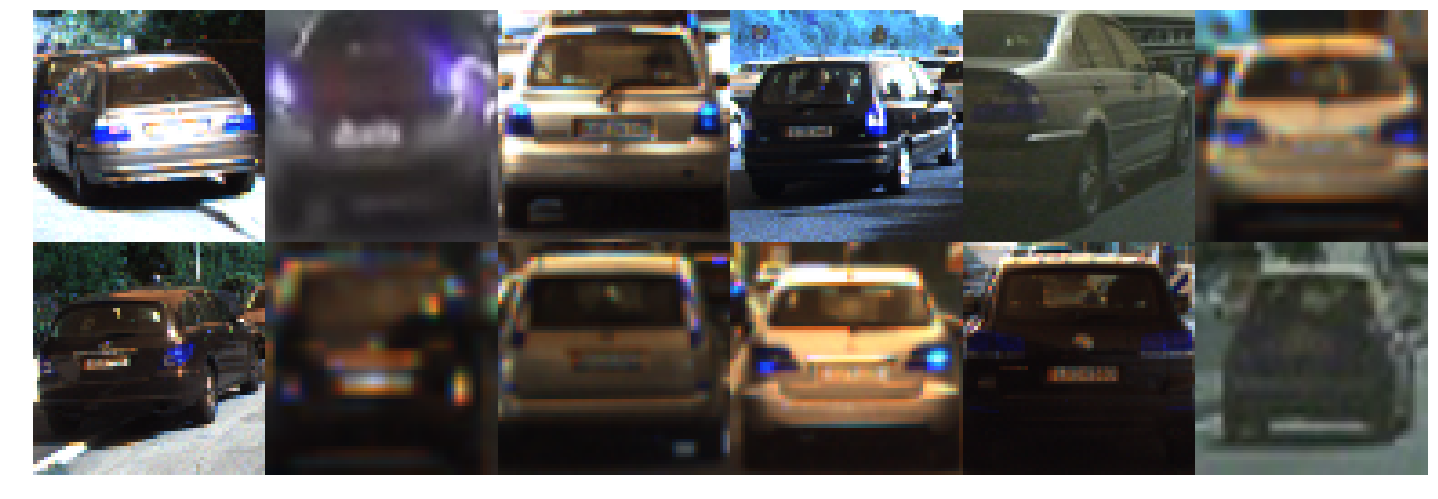

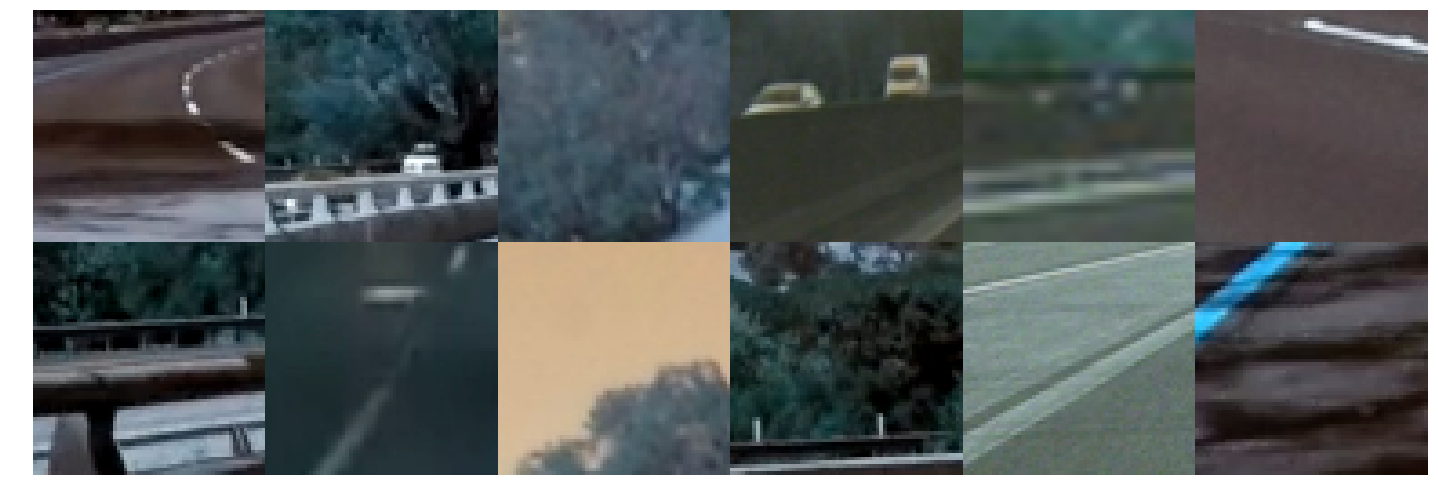

In [3]:
files_cars = glob.glob('./source_images/vehicles/**/*.png')
files_noncars = glob.glob('./source_images/non-vehicles/**/*.png')
print("Cars in dataset: {}; Non-cars in dataset: {}".format(len(files_cars), len(files_noncars)))

preview_cars = load_images(files_cars, num=12)
display_image_set(preview_cars, "cars")

preview_noncars = load_images(files_noncars, num=12)
display_image_set(preview_noncars, "noncars")

In [4]:
def to_colorspace(img_init, space='RGB'):
    img = np.copy(img_init)
    
    if space == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif space == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif space == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif space == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    elif space == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif space == 'gray':
        return np.expand_dims(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 2)
    else: 
        return img
    
def extract_hog(img, orient, ppc, cpb):
    feature, preview = hog(img, orientations=orient, pixels_per_cell=ppc, cells_per_block=cpb, 
                visualise=True, feature_vector=True)
    preview *= 255.0 / preview.max()
    preview = np.expand_dims(preview, 2)
    preview = np.array(cv2.merge((preview, preview, preview)), np.uint8)
    
    return feature, preview

def hog_features(img, orient, pix_per_cell, cell_per_block, channel=None):
    ppc = (pix_per_cell, pix_per_cell)
    cpb = (cell_per_block, cell_per_block)
    previews = np.empty([0, img.shape[0], img.shape[1], img.shape[2]], dtype = np.uint8)
    
    if channel is None:
        features = []

        for ch in range(img.shape[2]):
            feature, preview = extract_hog(img[:,:,ch], orient, ppc, cpb)
            features.append(feature)  
            previews = np.append(previews, preview[None,:], axis=0)

        features = np.ravel(features)
        features = np.array(features).astype(np.float64)
    else:
        feature, preview = extract_hog(img[:,:,channel], orient, ppc, cpb)
        previews = np.append(previews, preview[None,:], axis=0)
        features = np.array(feature).astype(np.float64)
        
    return features, previews
    

def hog_images(imgs, channel=None, orient=9, pix_per_cell=8, cell_per_block=8, colorspace='YUV'):
    features = []
    previews = np.empty([0, imgs.shape[1], imgs.shape[2], imgs.shape[3]], dtype = np.uint8)

    for img in imgs:
        img_cc = to_colorspace(img, colorspace)
        
        if channel is None:
            previews = np.append(previews, img_cc[None,:], axis=0)
        else:
            preview = np.array(cv2.merge((img_cc[:,:,channel], img_cc[:,:,channel], img_cc[:,:,channel])), np.uint8)
            previews = np.append(previews, preview[None,:], axis=0)
            
        feature, preview = hog_features(img_cc, orient, pix_per_cell, cell_per_block, channel)
        features.append(feature)
        previews = np.append(previews, preview, axis=0)

    return features, previews

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


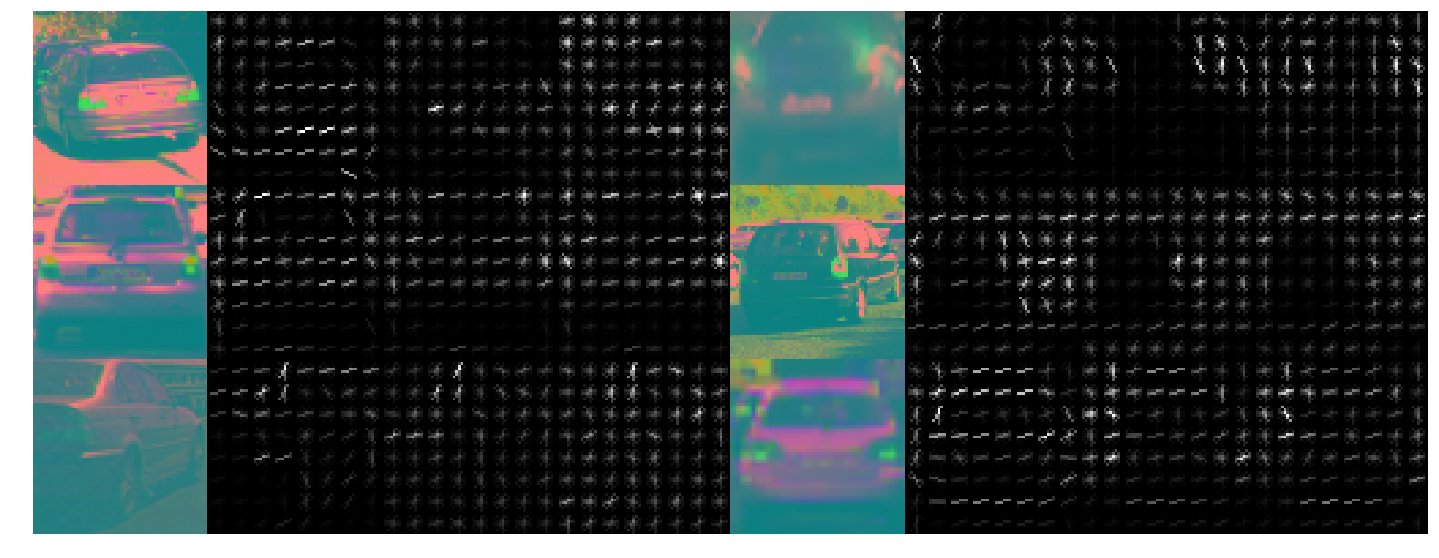

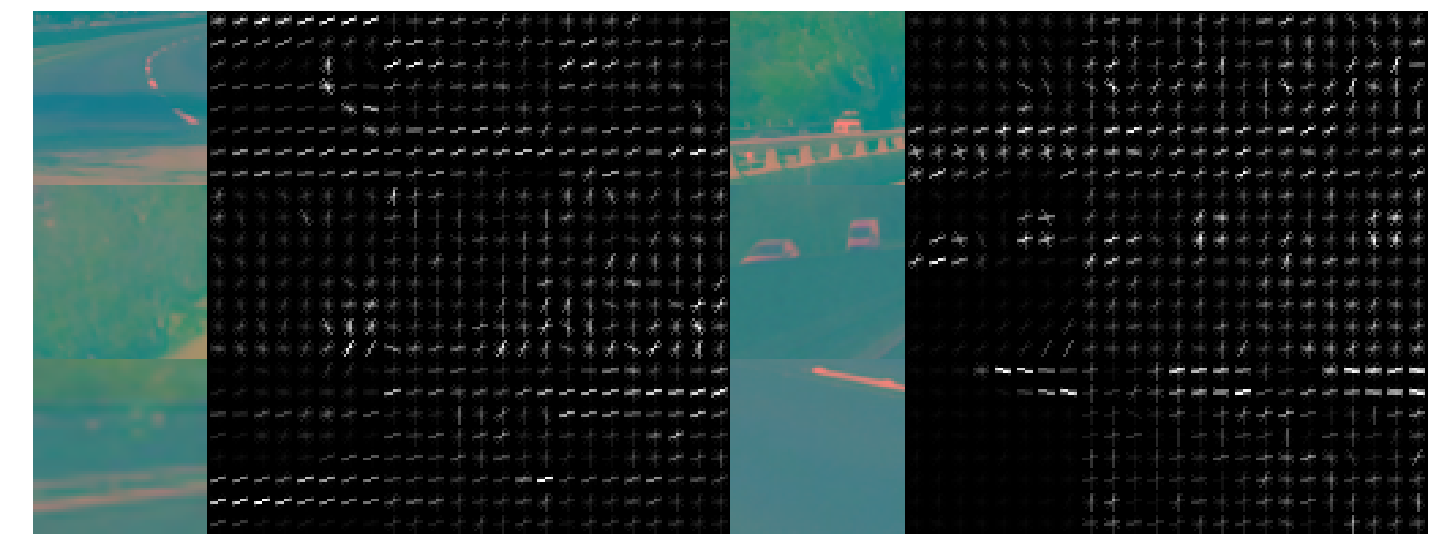

In [5]:
_, preview_hog_cars = hog_images(preview_cars[:6])
display_image_set(preview_hog_cars, "hog_cars", cols_num=8)

_, preview_hog_noncars = hog_images(preview_noncars[:6])
display_image_set(preview_hog_noncars, "hog_noncars", cols_num=8)

In [8]:
imgs = load_images(files_cars, num=100)

colorspaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
orientations = range(6, 13)
px_per_cells = range(6, 17)
cells_per_blocks = range(1, 4)
channels = [None, 0, 1, 2]

for space in colorspaces:
    for orientation in orientations:
        for px_per_cell in px_per_cells:
            for cells_per_block in cells_per_blocks:
                for channel in channels:
                    t = time.time()
                    hog_images(imgs, channel=channel, orient=orientation, pix_per_cell=px_per_cell, 
                                                   cell_per_block=cells_per_block, colorspace=space)
                    t2 = time.time()
                    print('Images: {} | Time: {}sec | Space {} | Orient {} | PPC {} | CPB {} | Channel {}'
                          .format(len(imgs), round(t2 - t, 2), space, orientation, px_per_cell, cells_per_block, channel))

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Images: 100 | Time: 19.65sec | Space RGB | Orient 6 | PPC 6 | CPB 1 | Channel None
Images: 100 | Time: 6.96sec | Space RGB | Orient 6 | PPC 6 | CPB 1 | Channel 0
Images: 100 | Time: 6.76sec | Space RGB | Orient 6 | PPC 6 | CPB 1 | Channel 1
Images: 100 | Time: 6.65sec | Space RGB | Orient 6 | PPC 6 | CPB 1 | Channel 2
Images: 100 | Time: 20.54sec | Space RGB | Orient 6 | PPC 6 | CPB 2 | Channel None
Images: 100 | Time: 6.4sec | Space RGB | Orient 6 | PPC 6 | CPB 2 | Channel 0
Images: 100 | Time: 6.65sec | Space RGB | Orient 6 | PPC 6 | CPB 2 | Channel 1
Images: 100 | Time: 6.35sec | Space RGB | Orient 6 | PPC 6 | CPB 2 | Channel 2
Images: 100 | Time: 24.58sec | Space RGB | Orient 6 | PPC 6 | CPB 3 | Channel None
Images: 100 | Time: 8.66sec | Space RGB | Orient 6 | PPC 6 | CPB 3 | Channel 0
Images: 100 | Time: 8.64sec | Space RGB | Orient 6 | PPC 6 | CPB 3 | Channel 1
Images: 100 | Time: 11.19sec | Space RGB | Orient 6 | PPC 6 | CPB 3 | Channel 2
Images: 100 | Time: 21.11sec | Space RGB

Images: 100 | Time: 2.06sec | Space RGB | Orient 6 | PPC 14 | CPB 2 | Channel 1
Images: 100 | Time: 1.84sec | Space RGB | Orient 6 | PPC 14 | CPB 2 | Channel 2
Images: 100 | Time: 5.61sec | Space RGB | Orient 6 | PPC 14 | CPB 3 | Channel None
Images: 100 | Time: 1.82sec | Space RGB | Orient 6 | PPC 14 | CPB 3 | Channel 0
Images: 100 | Time: 1.85sec | Space RGB | Orient 6 | PPC 14 | CPB 3 | Channel 1
Images: 100 | Time: 2.38sec | Space RGB | Orient 6 | PPC 14 | CPB 3 | Channel 2
Images: 100 | Time: 6.22sec | Space RGB | Orient 6 | PPC 15 | CPB 1 | Channel None
Images: 100 | Time: 2.03sec | Space RGB | Orient 6 | PPC 15 | CPB 1 | Channel 0
Images: 100 | Time: 2.39sec | Space RGB | Orient 6 | PPC 15 | CPB 1 | Channel 1
Images: 100 | Time: 1.92sec | Space RGB | Orient 6 | PPC 15 | CPB 1 | Channel 2
Images: 100 | Time: 6.42sec | Space RGB | Orient 6 | PPC 15 | CPB 2 | Channel None
Images: 100 | Time: 2.43sec | Space RGB | Orient 6 | PPC 15 | CPB 2 | Channel 0
Images: 100 | Time: 2.14sec | S

Images: 100 | Time: 5.74sec | Space RGB | Orient 7 | PPC 12 | CPB 1 | Channel None
Images: 100 | Time: 1.54sec | Space RGB | Orient 7 | PPC 12 | CPB 1 | Channel 0
Images: 100 | Time: 1.44sec | Space RGB | Orient 7 | PPC 12 | CPB 1 | Channel 1
Images: 100 | Time: 1.54sec | Space RGB | Orient 7 | PPC 12 | CPB 1 | Channel 2
Images: 100 | Time: 4.34sec | Space RGB | Orient 7 | PPC 12 | CPB 2 | Channel None
Images: 100 | Time: 1.43sec | Space RGB | Orient 7 | PPC 12 | CPB 2 | Channel 0
Images: 100 | Time: 1.51sec | Space RGB | Orient 7 | PPC 12 | CPB 2 | Channel 1
Images: 100 | Time: 2.1sec | Space RGB | Orient 7 | PPC 12 | CPB 2 | Channel 2
Images: 100 | Time: 4.1sec | Space RGB | Orient 7 | PPC 12 | CPB 3 | Channel None
Images: 100 | Time: 1.08sec | Space RGB | Orient 7 | PPC 12 | CPB 3 | Channel 0
Images: 100 | Time: 0.89sec | Space RGB | Orient 7 | PPC 12 | CPB 3 | Channel 1
Images: 100 | Time: 1.41sec | Space RGB | Orient 7 | PPC 12 | CPB 3 | Channel 2
Images: 100 | Time: 2.79sec | Spa

KeyboardInterrupt: 

In [6]:
imgs_cars = load_images(files_cars[:10])
imgs_noncars = load_images(files_noncars[:10])

features_cars, _ = hog_images(imgs_cars, orient=11, pix_per_cell=16, cell_per_block=2, colorspace='YUV')
features_noncars, _ = hog_images(imgs_noncars, orient=11, pix_per_cell=16, cell_per_block=2, colorspace='YUV')

X = np.append(features_cars, features_noncars, axis=0)
y = np.append(np.ones(len(features_cars)), np.zeros(len(features_noncars)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Train features {}, labels {}".format(X_train.shape, y_train.shape))
print("Test features {}, labels {}".format(X_test.shape, y_test.shape))

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Train features (16, 1188), labels (16,)
Test features (4, 1188), labels (4,)


In [7]:
t = time.time()
svc = LinearSVC()
svc.fit(X_train, y_train)
t2 = time.time()
print('Training time', round(t2 - t, 2))
print('Test Accuracy', round(svc.score(X_test, y_test), 4))

batch = 10
print('Prediction:', svc.predict(X_test[0:batch]))
print('True Label:', y_test[0:batch])

Training time 0.01
Test Accuracy 1.0
Prediction: [ 1.  1.  0.  0.]
True Label: [ 1.  1.  0.  0.]


In [8]:
def find_cars(img, ystart, ystop, scale, svc, show_all_rectangles=True):
    orient=11
    ppc=16
    cpb=2
    
    rectangles = []
    img = img.astype(np.float32) / 255.0
    img_tosearch = img[ystart:ystop, :,:]
    ctrans_tosearch = to_colorspace(img_tosearch, 'YUV')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // ppc) + 1
    nyblocks = (ch1.shape[0] // ppc) + 1
    nfeat_per_block = orient*cpb**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // ppc)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    feature_0 = hog(ch1, orientations=orient, pixels_per_cell=(ppc, ppc), cells_per_block=(cpb, cpb),
                                       visualise=False, feature_vector=False)
    feature_1 = hog(ch2, orientations=orient, pixels_per_cell=(ppc, ppc), cells_per_block=(cpb, cpb),
                                       visualise=False, feature_vector=False)
    feature_2 = hog(ch3, orientations=orient, pixels_per_cell=(ppc, ppc), cells_per_block=(cpb, cpb),
                                       visualise=False, feature_vector=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step

            hog_feat1 = feature_0[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = feature_1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = feature_2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            hog_features = hog_features.reshape(1, -1)
            xleft = xpos * ppc
            ytop = ypos * ppc
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

test_img = mpimg.imread('./test_images/test1.jpg')
ystart = 400
ystop = 656
scale = 1.5
rectangles = find_cars(test_img, ystart, ystop, scale, svc)

print(len(rectangles), 'rectangles found in image')

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


100 rectangles found in image


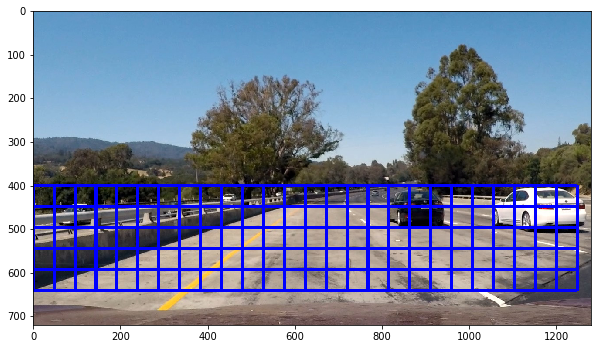

In [9]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    random_color = False

    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True

        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)

    return imcopy

test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.show()

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Number of boxes:  78


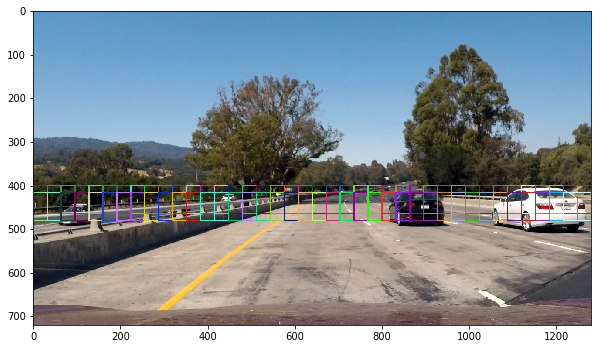

In [10]:
rects = []

ystart = 400
ystop = 464
scale = 1.0

rects.append(find_cars(test_img, ystart, ystop, scale, svc))
ystart = 416
ystop = 480
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, svc))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
print('Number of boxes: ', len(rectangles))

plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.show()

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Number of boxes:  50


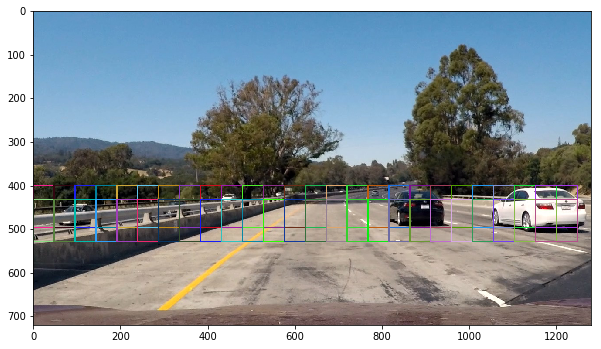

In [11]:
rects = []

ystart = 400
ystop = 496
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, svc))
ystart = 432
ystop = 528
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, svc))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
print('Number of boxes: ', len(rectangles))

plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.show()

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Number of boxes:  38


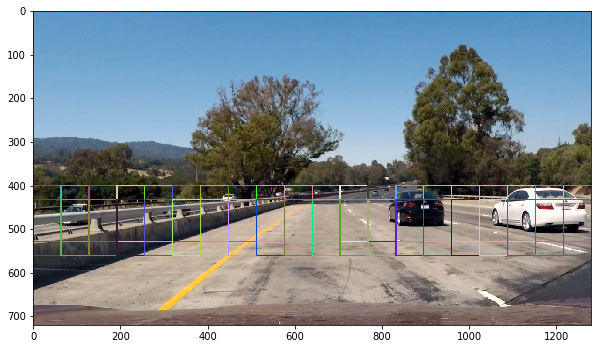

In [12]:
rects = []

ystart = 400
ystop = 528
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, svc))
ystart = 432
ystop = 560
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, svc))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
print('Number of boxes: ', len(rectangles))

plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.show()

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Number of boxes:  24


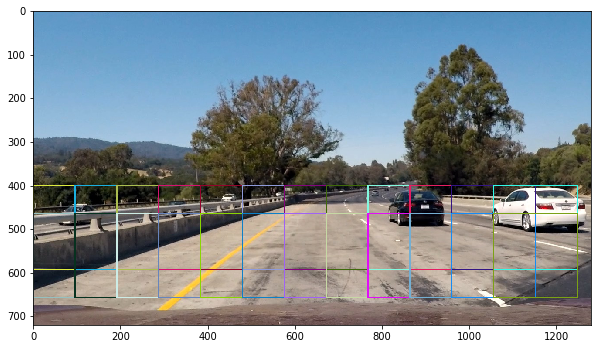

In [13]:
rects = []

ystart = 400
ystop = 596
scale = 3.0
rects.append(find_cars(test_img, ystart, ystop, scale, svc))
ystart = 464
ystop = 660
scale = 3.0
rects.append(find_cars(test_img, ystart, ystop, scale, svc))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))
plt.show()

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


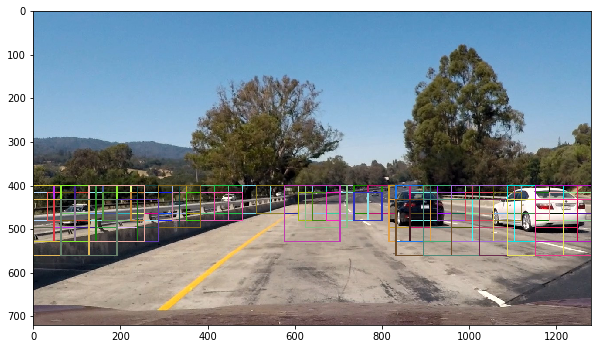

In [14]:
rectangles = []

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


ystart = 400
ystop = 464
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
ystart = 416
ystop = 480
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
ystart = 400
ystop = 496
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
ystart = 432
ystop = 528
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
ystart = 400
ystop = 528
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
ystart = 432
ystop = 560
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
ystart = 400
ystop = 596
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
ystart = 464
ystop = 660
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.show()

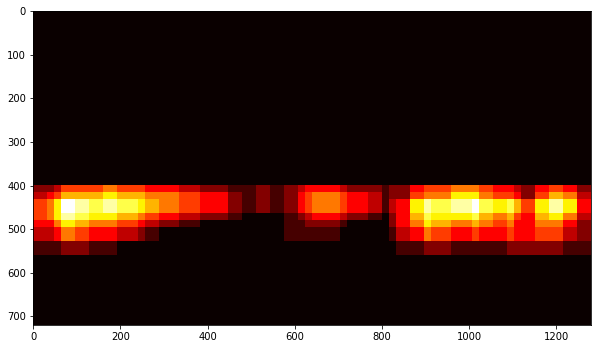

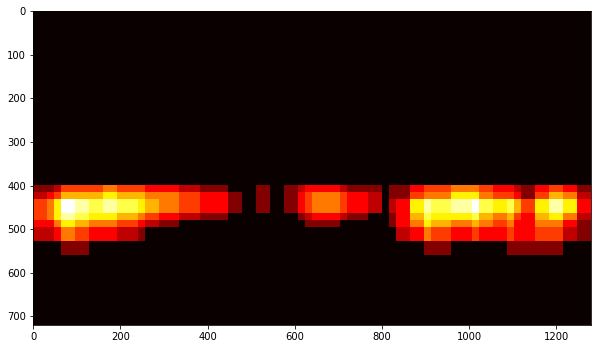

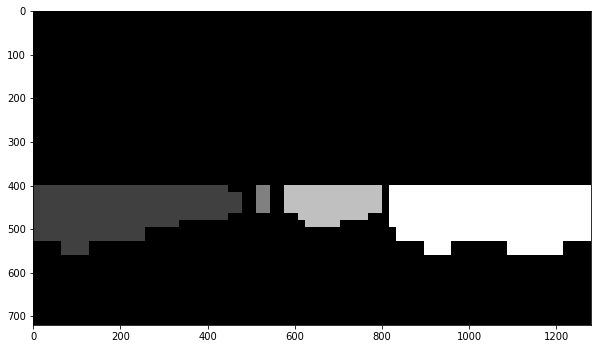

In [15]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
plt.show()

heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
plt.show()

labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
plt.show()

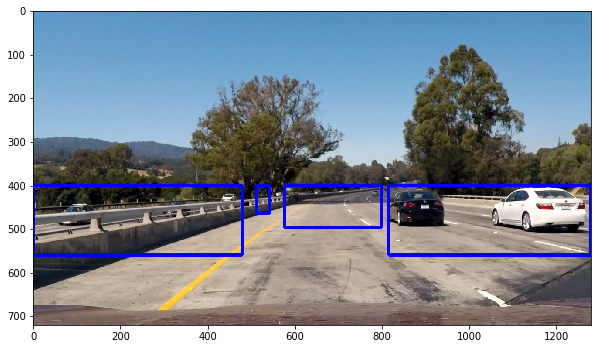

In [16]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
plt.show()

In [17]:
def process_frame(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


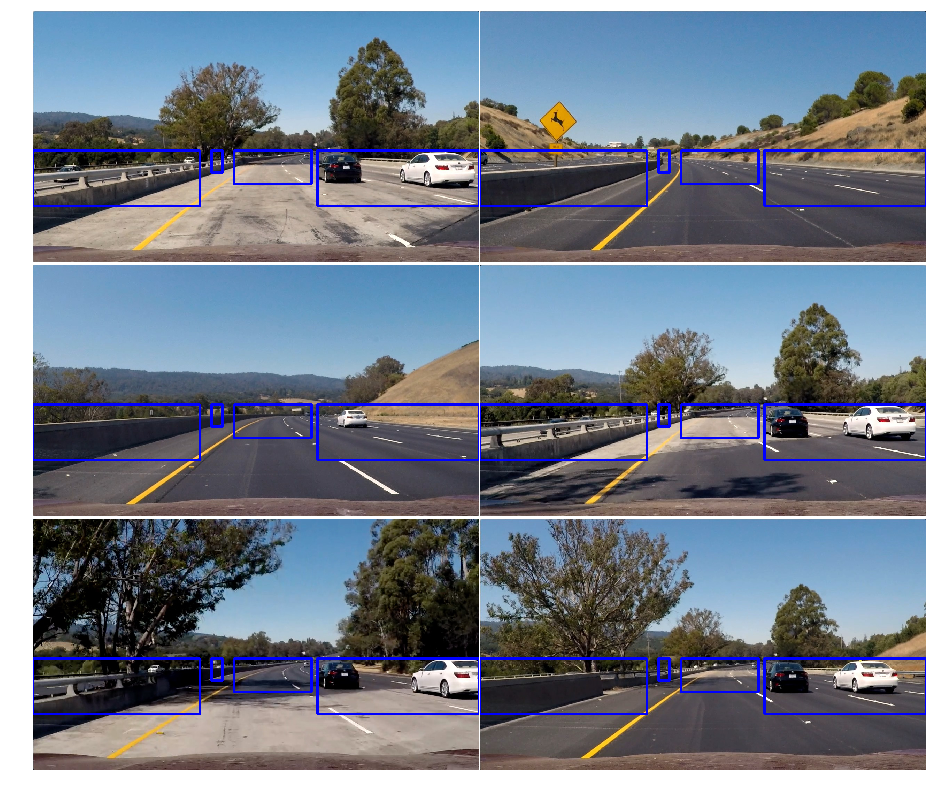

In [18]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')
    
plt.show()

In [22]:
test_out_file = './output_videos/test_video_out.mp4'
clip_test = VideoFileClip('./source_videos/test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video ./output_videos/test_video_out.mp4
[MoviePy] Writing video ./output_videos/test_video_out.mp4


 97%|█████████▋| 38/39 [00:32<00:00,  1.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/test_video_out.mp4 

CPU times: user 18.7 s, sys: 3.23 s, total: 21.9 s
Wall time: 36.1 s


In [23]:

# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

In [24]:
def process_frame_for_video(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(test_img, ystart, ystop, scale, svc, show_all_rectangles=False))
 
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [25]:
det = Vehicle_Detect()

test_out_file2 = './output_videos/test_video_out.mp4'
clip_test2 = VideoFileClip('./source_videos/test_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_frame_for_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video ./output_videos/test_video_out.mp4
[MoviePy] Writing video ./output_videos/test_video_out.mp4


 97%|█████████▋| 38/39 [00:37<00:01,  1.06s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/test_video_out.mp4 

CPU times: user 20.5 s, sys: 3.24 s, total: 23.8 s
Wall time: 42.2 s


In [26]:
det = Vehicle_Detect()

proj_out_file = './output_videos/project_video_out.mp4'
clip_proj = VideoFileClip('./source_videos/project_video.mp4') #.subclip(23,26)  # subclip = only specified span of video
#clip_proj.save_frame('./test_images/project1.jpg', t=1.0) # saves the frame at time = t seconds
clip_proj_out = clip_proj.fl_image(process_frame_for_video)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video_out.mp4
[MoviePy] Writing video ./output_videos/project_video_out.mp4


 19%|█▉        | 240/1261 [04:20<18:49,  1.11s/it]ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



KeyboardInterrupt: 